In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 99% !important;}</style>"))

In [3]:
import numpy   as np
import scipy   as sp
import pandas  as pd
import seaborn as sns
import matplotlib
import kabuki
from matplotlib import pyplot as plt
import ipyparallel
from ipyparallel import parallel
import hddm
import os

%matplotlib inline
np.set_printoptions(suppress = True)

In [8]:
os.chdir("/Users/user/Desktop/Experiments/Nick/AttentionSaccade")
sublist = [1,2,3,4,5,6,7,8,9]

datafname = os.path.join(os.getcwd(), 'AttentionSaccade_BehaviouralData_All.csv')
data = pd.read_csv(datafname, sep = ',', index_col = False) #read in collated data
data = data.drop(data.columns[0], axis = 1) #drop unnamed, random column that has appeared in the data
attention = data.loc[data['task']==1]
saccade   = data.loc[data['task']==2]
attention.columns

Index([u'subject', u'session', u'trial', u'task', u'cuecol', u'cueloc',
       u'validity', u'targloc', u'targtilt', u'delay', u'resp', u'time',
       u'corr'],
      dtype='object')

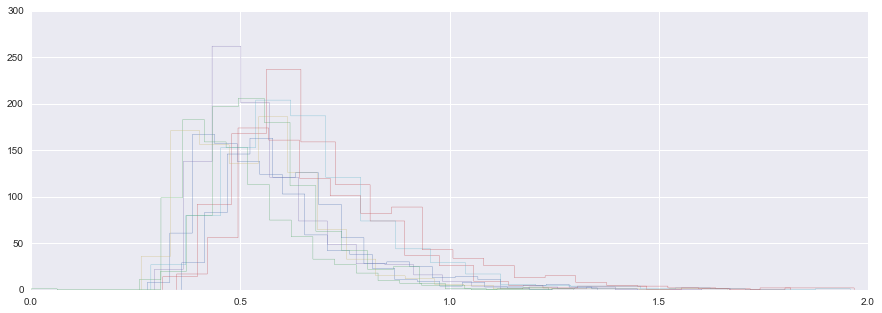

In [9]:
plt.rcParams['figure.figsize'] = (15,5)
for i, subject in attention.groupby('subject'):
    subject.time.hist(bins = 20, histtype = 'step')

In [10]:
attention = attention[['subject', 'time', 'corr', 'validity']] #select dataframe down to just these variables
attention = attention.rename(columns={'time':'rt', "corr":'response','subject':'subj_idx'}) #rename for use with hddm package
attention = attention[np.isnan(attention['rt'])==False] #remove trials with no response

attval = attention[attention['validity']==1]
attinv = attention[attention['validity']==0]

#rename colding of validity to string instead of number
attention.loc[attention.validity==1, 'validity'] = 'valid'
attention.loc[attention.validity==0, 'validity'] = 'invalid'
print attval.shape, attinv.shape

#attention.shape
#attention = attention[attention['rt']<0.05]
#np.where(np.isnan(attention['rt'])) #check for missing data

(6891, 4) (1721, 4)


In [24]:
#drift diffusion model on attention task data
model = hddm.HDDM(data= attention, p_outlier=0.05, bias = True,
                 depends_on = {'a':'validity', 'v':'validity',
                               't':'validity', 'z':'validity',
                               'sv':'validity', 'st':'validity'},
                 include = {'sv', 'st'}) #depends_on : model parameters estimated separately for validity conditions (so we can look at validity effect on model parameters)
model.find_starting_values()
model.sample(2000, burn=20)

 [-----------------100%-----------------] 2001 of 2000 complete in 41766.6 sec

In [72]:
# a, v, t, z parameters for each participant, and the group (mean + stds)
# a = decision threshold
# v = drift rate
# t = non-decision time parameter
# z = prepotent response bias
stats = model.gen_stats()
stats[stats.index.isin(['a(valid)','a(invalid)',
                        'v(valid)','v(invalid)',
                        't(valid)','t(invalid)',
                        'z(valid)','z(invalid)',
                        'sv(valid)', 'sv(invalid)', 'st(valid)', 'st(invalid)'])]
stats

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a(invalid),0.981086,0.0576525,0.867797,0.942576,0.98148,1.01794,1.10219,0.00221528
a(valid),1.01705,0.0541693,0.911516,0.980994,1.01649,1.05234,1.12614,0.00194116
a_std,0.15219,0.0341336,0.102428,0.128287,0.146637,0.170604,0.234373,0.00109175
a_subj(invalid).1,0.98967,0.0562975,0.89034,0.948224,0.986252,1.02696,1.11061,0.00249097
a_subj(valid).1,0.926223,0.0312767,0.865847,0.905398,0.926055,0.947083,0.988129,0.00171403
a_subj(invalid).2,0.83694,0.0482311,0.744197,0.803295,0.83613,0.870063,0.932002,0.00194823
a_subj(valid).2,0.892004,0.0283384,0.841409,0.871976,0.890655,0.911035,0.948096,0.00126651
a_subj(invalid).3,1.07536,0.0572482,0.967854,1.03507,1.07336,1.113,1.19589,0.00269155
a_subj(valid).3,1.0297,0.0333182,0.963802,1.0073,1.02884,1.05233,1.09536,0.00195267
a_subj(invalid).4,1.08228,0.0596564,0.968036,1.04011,1.0804,1.12315,1.20162,0.00268846


In [65]:
#stats.index
statstoplot = ['a(valid)','a(invalid)','v(valid)','v(invalid)','t(valid)','t(invalid)','z(valid)','z(invalid)', 'sv(valid)', 'sv(invalid)', 'st(valid)', 'st(invalid)']
plot_stats = pd.DataFrame(stats.loc[statstoplot, 'mean'])
print plot_stats

                 mean
a(valid)      1.01705
a(invalid)   0.981086
v(valid)      2.21882
v(invalid)    1.29344
t(valid)     0.412617
t(invalid)   0.509479
z(valid)      0.57941
z(invalid)   0.592538
sv(valid)       1.161
sv(invalid)   1.02009
st(valid)    0.219128
st(invalid)  0.243453


In [106]:
indices = ['a(valid)' , 'a(invalid)' ,'a_std' , 'v(valid)' , 'v(invalid)' ,'v_std' ,
           't(valid)' , 't(invalid)' ,'t_std' , 'z(valid)' , 'z(invalid)' ,'z_std', 'sv(valid)', 'sv(invalid)', 'st(valid)', 'st(invalid)']
#           'sv(valid)', 'sv(invalid)', 'st(valid)', 'st(invalid)'])
stats = pd.DataFrame(stats)
plotsub_stats = stats.drop(indices); plotsub_stats = pd.DataFrame(plotsub_stats.loc[:,'mean'])



In [110]:
plotsub_stats['modelparam'] = np.sort(np.tile(range(1,5),18))
plotsub_stats['validity']   = np.tile([1,2],36)
plotsub_stats['subject']    = np.tile(np.sort(np.tile(range(1,10), 2)),4)

plotsub_stats.loc[plotsub_stats.modelparam ==1, 'modelparam'] = 'a'; plotsub_stats.loc[plotsub_stats.modelparam ==2, 'modelparam'] = 'v'
plotsub_stats.loc[plotsub_stats.modelparam ==3, 'modelparam'] = 't'; plotsub_stats.loc[plotsub_stats.modelparam ==4, 'modelparam'] = 'z'

plotsub_stats.loc[plotsub_stats.validity==1, 'validity'] = 'invalid';plotsub_stats.loc[plotsub_stats.validity==2, 'validity'] = 'valid'

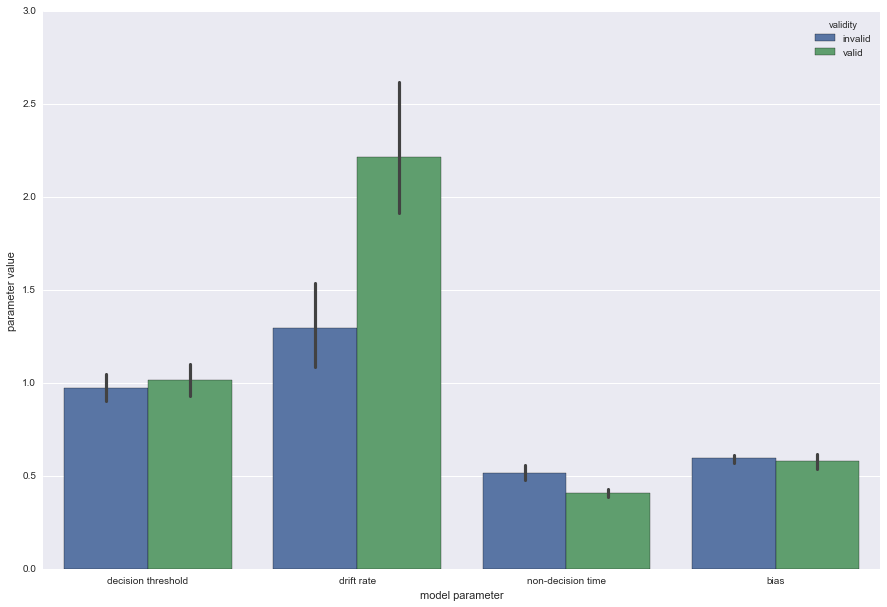

In [126]:
plt.rcParams['figure.figsize'] = (15,10)
ax = sns.barplot(data = plotsub_stats, x = 'modelparam', hue = 'validity', y = 'mean')

ax.set_xticklabels(['decision threshold', 'drift rate', 'non-decision time', 'bias'])
ax.set_ylabel('parameter value'); ax.set_xlabel('model parameter')
plt.savefig(os.path.join(os.getcwd(), 'modelparameter_barplot_9subs'))

In [71]:
plot_stats['modelparam'] = np.sort(np.tile(range(1,7),2))
plot_stats['validity']   = np.tile([1,2],6)
plot_stats.loc[plot_stats.modelparam == 1, 'modelparam'] = 'a' ; plot_stats.loc[plot_stats.modelparam == 2, 'modelparam'] = 'v'
plot_stats.loc[plot_stats.modelparam == 3, 'modelparam'] = 't' ; plot_stats.loc[plot_stats.modelparam == 4, 'modelparam'] = 'z'
plot_stats.loc[plot_stats.modelparam == 5, 'modelparam'] = 'sv'; plot_stats.loc[plot_stats.modelparam == 6, 'modelparam'] = 'st'
plot_stats.loc[plot_stats.validity == 1, 'validity'] = 'valid' ; plot_stats.loc[plot_stats.validity == 2, 'validity'] = 'invalid'
print plot_stats

                 mean modelparam validity
a(valid)      1.01705          a    valid
a(invalid)   0.981086          a  invalid
v(valid)      2.21882          v    valid
v(invalid)    1.29344          v  invalid
t(valid)     0.412617          t    valid
t(invalid)   0.509479          t  invalid
z(valid)      0.57941          z    valid
z(invalid)   0.592538          z  invalid
sv(valid)       1.161         sv    valid
sv(invalid)   1.02009         sv  invalid
st(valid)    0.219128         st    valid
st(invalid)  0.243453         st  invalid


/Users/user/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


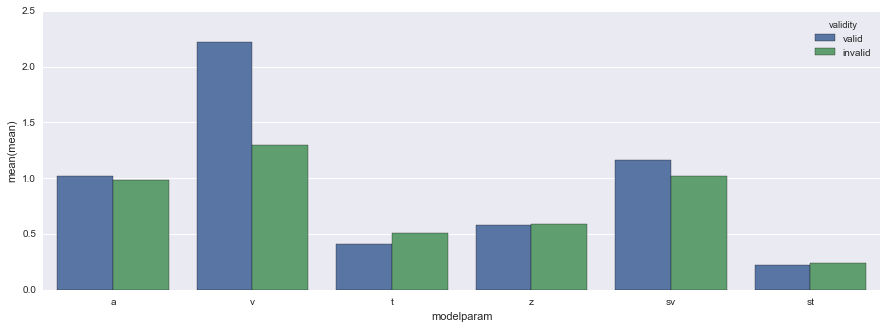

In [70]:
sns.barplot(data=plot_stats, x = 'modelparam', y = 'mean', hue = 'validity')

In [67]:
help(sns.barplot,x = parameter, y = mean, hue = validity)

NameError: name 'parameter' is not defined

In [23]:
# model valid and invalid trials separately
modelvalid = hddm.HDDM(data = attval, p_outlier=0.05, bias = True)
modelvalid.find_starting_values()
modelvalid.sample(2000, burn = 20)

modelinv = hddm.HDDM(data=attinv, p_outlier=0.05, bias = True)
modelinv.find_starting_values()
modelinv.sample(2000, burn = 20)

#output stats for the independent models
stats_valid = modelvalid.gen_stats()
stats_valid[stats_valid.index.isin(['a', 'a_std', 'v','v_std', 't', 't_std', 'z', 'z_std'])] #only show group parameters
stats_invalid = modelinv.gen_stats()
stats_invalid[stats_invalid.index.isin(['a', 'a_std', 'v','v_std', 't', 't_std', 'z', 'z_std'])]


/Users/user/anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/user/anaconda/lib/python2.7/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2000 of 2000 complete in 116.6 sec